"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [1]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum

[108 117]
[  0 108 117 200]
[0.46123041 0.74727116 0.03039635]


Text(0, 0.5, 'Spikes')

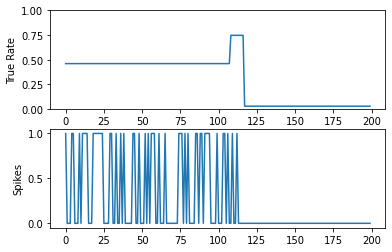

In [95]:
# Some poisson spiking
length = 200
states = 3
fit = int(1e5)
samples = 2000

true_tau = np.cumsum(np.random.random(states))
true_tau /= np.max(true_tau)
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)
state_inds = np.concatenate([np.zeros((1)),true_tau])
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:-1]

true_lambda = np.random.random(states)

print(true_tau)
print(state_inds)
print(true_lambda)

true_r = np.zeros(length)
for num, val in enumerate(true_lambda):
    true_r[state_inds[num]:state_inds[num+1]] = val
  
spikes = np.random.random(length) < true_r
#data_vec = np.random.poisson(true_r)

fig,ax = plt.subplots(2,1)
ax[0].plot(true_r)
ax[0].set_ylim(0,1)
ax[1].plot(spikes)
ax[0].set_ylabel("True Rate")
ax[1].set_ylabel("Spikes")

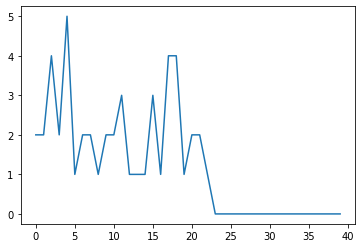

In [96]:
bin_width = 5
data_vec = np.sum(np.reshape(spikes,(-1,bin_width)),axis=-1)
fin_length = len(data_vec)
idx = np.arange(fin_length)
plt.plot(data_vec)

In [97]:
mean_vals = np.array([np.mean(x,axis=-1) for x in np.array_split(data_vec,states,axis=-1)])
print(mean_vals)

[2.14285714 1.46153846 0.        ]


In [98]:
1/(np.mean(mean_vals))

0.8323170731707318

In [99]:
even_switches = np.linspace(0,1,states+1)[1:-1]
even_switches

array([0.33333333, 0.66666667])

In [126]:
def var_sig_exp_tt(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+tt.exp(-tt.exp(b)*x))

def var_sig_tt(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+tt.exp(-b*x))

with pm.Model() as model:
    sig_b = pm.Normal('sig_b', 0,2, shape = states-1)
    #sig_b = pm.HalfCauchy('sig_b', 2, testval = 0.1)
    
    # Finite, but somewhere on the lower end, Beta prior
    
    lambda_latent = pm.Exponential('lambda_latent', 
                                    1/(np.mean(mean_vals)), 
                                    shape = states)#,
                                  #testval = mean_vals + 1e-3)

    a = pm.HalfCauchy('a_tau', 10, shape = states - 1)
    b = pm.HalfCauchy('b_tau', 10, shape = states - 1)
    
    
    #tau_latent = pm.Beta('tau_latent', 2, 5, 
    tau_latent = pm.Beta('tau_latent', a, b, 
                         testval = even_switches,
                         shape = (states-1)).sort(axis=-1)    
    
    tau = pm.Deterministic('tau', 
            idx.min() + (idx.max() - idx.min()) * tau_latent)

In [106]:
lambda_latent.tag.test_value

array([0.83279222, 0.83279222, 0.83279222])

In [107]:
with model:
    weight1 = var_sig_exp_tt(idx-tau[0],sig_b[0])
    weight2 = var_sig_exp_tt(idx-tau[1],sig_b[1])
    lambda_ =  pm.Deterministic('lambda_',
                                (1-weight1)*lambda_latent[0] + \
                    weight2*lambda_latent[1])
    lambda_bounded = pm.Potential("lambda_bounded", tt.switch(lambda_>0, lambda_, 0))
    
    #     weight_stack = var_sig_exp_tt(idx[np.newaxis,:]-tau[:,np.newaxis],sig_b)
    #     #weight_stack = tt.nnet.sigmoid(idx[np.newaxis,:]-tau[:,np.newaxis])
    #     weight_stack = tt.concatenate([np.ones((1,fin_length)),weight_stack],axis=0)
    #     inverse_stack = 1 - weight_stack[1:]
    #     inverse_stack = tt.concatenate([inverse_stack, np.ones((1,fin_length))],axis=0)
    #     weight_stack = np.multiply(weight_stack,inverse_stack)
    # lambda_ = pm.math.sum(np.multiply(weight_stack,lambda_latent[:,np.newaxis]),axis=0)

In [108]:
# plt.imshow(weight_stack.tag.test_value,aspect='auto')

(40,)


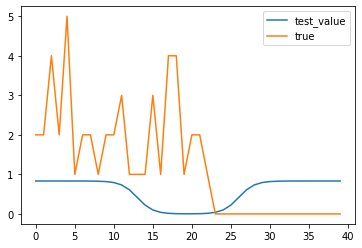

In [109]:
plt.plot(lambda_.tag.test_value,label='test_value')
plt.plot(data_vec,label='true')
plt.legend()
print(lambda_.tag.test_value.shape)

In [110]:
with model:
    # Add observations
    observation = pm.Poisson("obs", lambda_bounded, observed=data_vec)

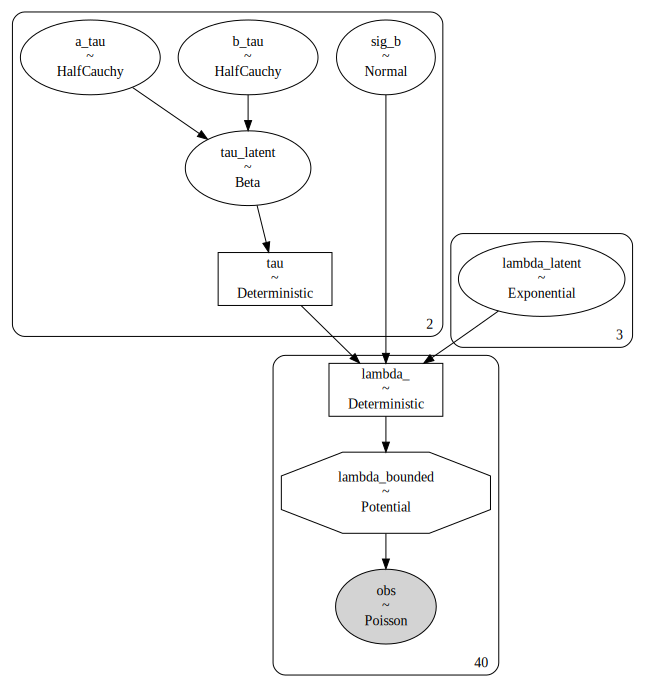

In [111]:
pm.model_to_graphviz(model)

In [112]:
with model:
    inference = pm.ADVI('full-rank')
    tracker = pm.callbacks.Tracker(
            mean=inference.approx.mean.eval,  # callable that returns mean
            std=inference.approx.std.eval,  # callable that returns std
        )
    approx = pm.fit(n=fit, method=inference,
                   callbacks=[tracker])
    trace = approx.sample(draws=samples)

Finished [100%]: Average Loss = -121.98


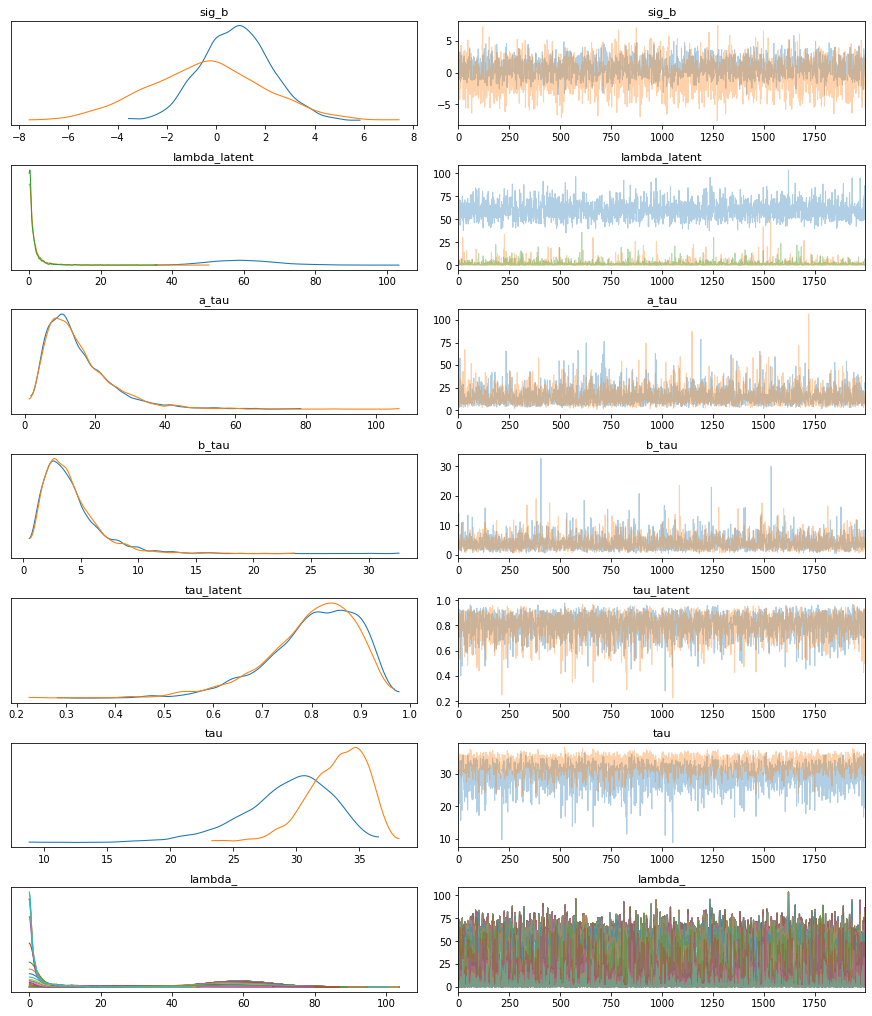

In [113]:
with model:
    pm.traceplot(trace)

In [114]:
def tracker_names_out(model):
    raw_rvs = model.free_RVs
    names = [x.name for x in raw_rvs]
    sizes = [x.tag.test_value.shape for x in raw_rvs]
    fin_sizes = [x[0] if x is not () else 1 for x in sizes]
    fin_names = [[this_name]*this_size for this_name, this_size in zip(names,fin_sizes)]
    fin_names = [x for y in fin_names for x in y]
    return fin_names

In [115]:
rv_names = tracker_names_out(model)
rv_names

['sig_b',
 'sig_b',
 'lambda_latent_log__',
 'lambda_latent_log__',
 'lambda_latent_log__',
 'a_tau_log__',
 'a_tau_log__',
 'b_tau_log__',
 'b_tau_log__',
 'tau_latent_logodds__',
 'tau_latent_logodds__']

In [116]:
tracker_mean = np.stack(tracker['mean'])
tracker_std = np.stack(tracker['std'])

In [117]:
tracker_mean

array([[ 2.30158512,  2.30358223,  2.30358451, ..., -0.18197114,
        -0.18197152, -0.18238085],
       [ 2.30142195,  2.30427444,  2.30405401, ..., -0.18133107,
        -0.18113608, -0.18185033],
       [ 2.30113245,  2.30347407,  2.30456182, ..., -0.18086533,
        -0.18037145, -0.18143552],
       ...,
       [ 2.55772934,  2.56353654,  1.25517573, ...,  4.08208406,
        -0.22545998, -0.33326854],
       [ 2.55758507,  2.56361699,  1.25545956, ...,  4.08190046,
        -0.22569975, -0.33308694],
       [ 2.55759084,  2.56385041,  1.25559116, ...,  4.08196968,
        -0.22545035, -0.33284094]])

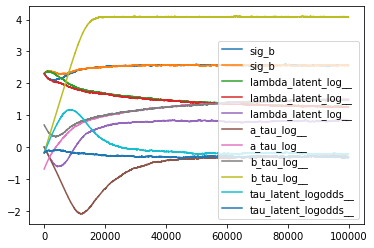

In [118]:
lineObjects = plt.plot(tracker_mean)
plt.legend(iter(lineObjects), rv_names)

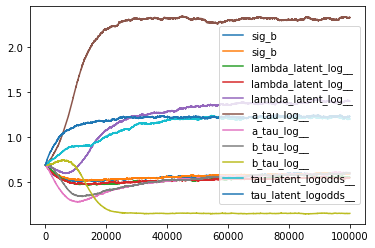

In [119]:
lineObjects = plt.plot(tracker_std)
plt.legend(iter(lineObjects), rv_names)

0.20316307225650934

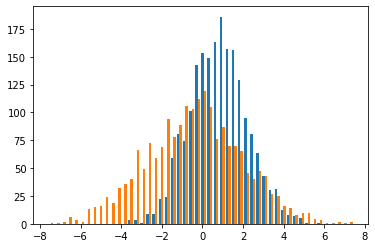

In [120]:
plt.hist(trace['sig_b'],50);
np.mean(trace['sig_b'])

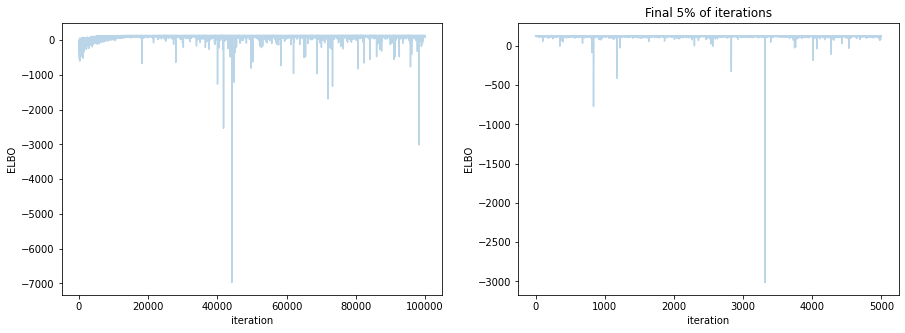

In [121]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(-approx.hist, alpha=.3)
ax[0].set_ylabel('ELBO')
ax[0].set_xlabel('iteration');

ind = int(fit - fit*0.05)
ax[1].plot(-approx.hist[ind:], alpha=.3)
ax[1].set_title('Final 5% of iterations')
ax[1].set_ylabel('ELBO')
ax[1].set_xlabel('iteration');

In [122]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)

Text(0.5, 1.0, 'Mean prediction')

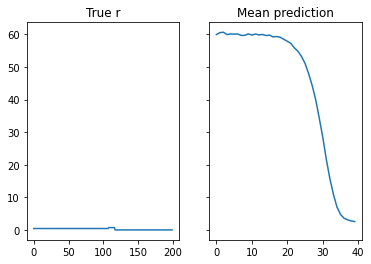

In [123]:
fig,ax = plt.subplots(1,2,sharey=True)
ax[0].plot(true_r)
ax[1].plot(np.mean(ppc['obs'],axis=0), alpha=1)
ax[0].set_title('True r')
ax[1].set_title('Mean prediction')

In [124]:
#min_val,max_val = min(true_r),max(true_r)
tau = trace['tau']
print(tau.shape)
mode_tau = stats.mode(np.vectorize(np.int)(tau),axis=0)[0][0]
mode_tau

(2000, 2)


array([30, 34])

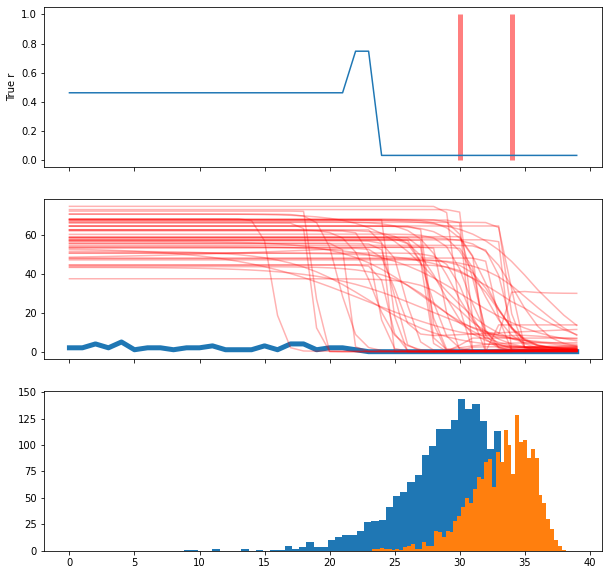

In [125]:
fig,ax = plt.subplots(3,1,sharex=True,figsize=(10,10))
ax[0].plot(true_r[::bin_width])
ax[0].set_ylabel('True r')
ax[1].plot(data_vec, linewidth = 5)
ax[1].plot(trace['lambda_'][:50].T,color='red', alpha = 0.3)
    
for tau_num, this_tau in enumerate(tau.T):
    ax[2].hist(this_tau,bins=50)
    ax[0].vlines(mode_tau[tau_num],0,1,color='red',alpha=0.5,linewidth=5)
